In [1]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib as plt
import cv2
from tensorflow.keras.models import load_model
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/sabahat/.local/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random', 'plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
# Image Processing Libraries
from tqdm import tqdm  # to show processing bar
from skimage.io import imread, imshow
from skimage.transform import resize

In [3]:
''' Standard Size of Images '''
img_width = 128 
img_hight = 128
img_channels = 3
# adjust randome seed size
seed = 42
np.random.seed = seed

### Resizing the Images

In [5]:
'''  
Data Preprocessing
''' 
train_path = 'PALM-Training400/'
test_path = 'Validation/'
train_ids = next(os.walk(train_path))[2]#next function return a tuple(all folders at 1 position
# test_ids = next(os.walk(test_path))[2]
# print(len(train_ids))
# print(len(test_ids))
X_train = np.zeros((len(train_ids),img_hight, img_width, img_channels), dtype=np.uint8)
# X_train.shape
Y_train = np.zeros((len(train_ids),img_hight, img_width, 1), dtype=np.bool) # for Masks
# Y_train.shape
#
""" Resizing Training Images  """
#
masks_path = next(os.walk('masks/'))[2]
# print(masks_path)
training_ids = sorted(train_ids)
masks_ids = sorted(masks_path)
indx = 0
print('Resizing Training Images and Masks')
for img_id in tqdm(training_ids):
    image = imread(train_path+img_id)[:,:,:img_channels]
    image = resize(image, (img_hight, img_width), mode='constant', preserve_range= True)
    X_train[indx] = image # fill empty X_train with values from images
    mask = np.zeros((img_hight, img_width, 1), dtype=np.bool)
#     for mask_file in next(os.walk(path+'/masks/'))[2]:
    test_mask = imread('masks/'+masks_ids[indx])
    test_mask = np.expand_dims(resize(test_mask,(img_hight, img_width), mode='constant', preserve_range=True), axis=-1)#
#     mask = np.maximum(mask, test_mask)
    Y_train[indx] = test_mask
    indx += 1 

  0%|          | 0/400 [00:00<?, ?it/s]

Resizing Training Images and Masks


100%|██████████| 400/400 [12:22<00:00,  1.86s/it]


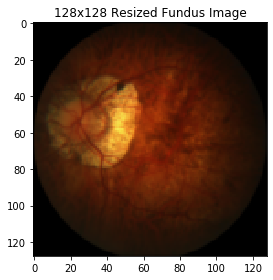

In [9]:
plt.title('128x128 Resized Fundus Image')
imshow(X_train[200])
plt.show()

_______
## Saving to a Folder
It will take mask and will draw circle arround it and after drwing circle, bitwise_and with origional fundus image and final mask_PPA combined image store in PP_images folder.

In [6]:
path = 'PPA_images'
for filename in tqdm(train_ids):
    mId = filename.split('.')[0]
    img = cv2.imread('masks/'+mId+'.bmp',0)
#     img = cv2.resize(img1, (400,400))
    ret,thresh = cv2.threshold(img,120,255,0)
    im2,contours,hierarchy = cv2.findContours(thresh, 1, 2)
    cnt = contours[0]
    M = cv2.moments(cnt)
    (x,y),radius = cv2.minEnclosingCircle(cnt)
    center = (int(x),int(y))
    radius = int(radius)
    radius += 11
    for i in range(1,110):
        img = cv2.circle(img,center,radius-i,(0,255,0),85)
    # print(radius)
    img2 = cv2.imread('fundus/'+filename,0)
    fimg = cv2.bitwise_or(img2,img)
    cv2.imwrite(os.path.join(path ,mId+'.jpg'), fimg)

  0%|          | 0/400 [00:00<?, ?it/s]


ValueError: not enough values to unpack (expected 3, got 2)

### Loading Saved Model

In [11]:
model = load_model('model_for_nuclei.h5') # loading saved model which will extract the Optic Disk

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


____
##### Helper function that will return the optic disk mask predicted by trained model

In [82]:
def predict(file_name):
    X_test = np.zeros((1,img_hight, img_width, img_channels), dtype=np.uint8)
    image = imread(file_name)
    image1 = resize(image, (img_hight, img_width), mode='constant', preserve_range=True)
    X_test = np.reshape(image1, X_test.shape)

    # Predicting
    predicted_valid = model.predict(X_test, verbose=1)
    preds_valid_t = (predicted_valid > 0.5).astype(np.uint8) # ceil the values(if > 0.5 then convert to 1)
    pred_img =  np.squeeze(preds_valid_t) # convert (1,128,128,1) to (128,128)
    return pred_img

### Extracting PPA Region

P0058.jpg
1/1 [==============================] - 0s 55ms/sample


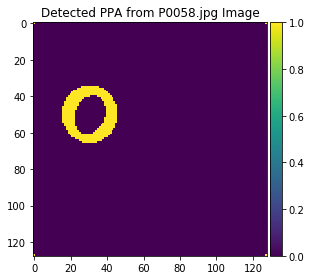

In [92]:
filename = train_ids[160] # select any number from range 0 to 400
# for filename in train_ids:
mask = predict('fundus/'+filename) # predicting mask from model
img = cv2.imread('PPA_images/'+filename,0)
image = resize(img, (img_hight, img_width), mode='constant', preserve_range=True)
t = (image > 217.0).astype(np.uint8)
fimg = cv2.bitwise_xor(t,mask)
plt.title('Detected PPA from '+filename+' Image')
imshow(fimg)
plt.show()